In [1]:
%matplotlib inline
import matplotlib
import numpy as np
import matplotlib.pyplot as plt

import claude.utils as cu
from claude.tx import qammod
from claude.models.NLIN import defaultParameters,\
                               calcConstants,\
                               calcNLIN

In [2]:
# System parameters
param = defaultParameters()
param.nSpans = 20

param.M = 64
constellation = qammod(param.M)

power = np.mean(np.abs(constellation)**2)
param.kur  = np.mean(np.abs(constellation)**4) / power**2
param.kur3 = np.mean(np.abs(constellation)**6) / power**3

print( param )

nPol:	2
lambda_:	1.55003597538907e-06
Fc:	193410000000000.0
D:	16.464
alpha:	0.2
beta2:	2.0999953937404486e-26
gamma:	1.3
nSpans:	20
spanLength:	100
noiseFigure:	5
PdBm:	1
Rs:	32
channels:	[-100.  -50.    0.   50.  100.]
nChannels:	5
chSpacing:	50
kur:	1.3809523809523807
kur3:	2.225785552316164
N_mc:	1000000
PD:	0
M:	64



In [3]:
# Calculate System constants
# Calculate Add terms
aseNoisePower, chi, X, intraConstAdd, interConstAdd = calcConstants(param)

In [4]:
# QAM
powerSweep = np.arange(-10, 4, 0.1)
NLINeffSNR = powerSweep - calcNLIN(param, powerSweep, aseNoisePower, chi, X, intraConstAdd, interConstAdd)

In [5]:
# Nonlinear Wizard http://nlinwizard.eng.tau.ac.il
wizard_powerSweep = [-10, -8, -6,-4, -2, 0, 2, 4]
wizard_effSNR = [5.91, 7.90, 9.88, 11.80, 13.49, 14.43, 13.73, 11.20]

In [6]:
# Fehenberger GN https://www.fehenberger.de/#sourcecode
fehen_powerSweep = [-10, -8, -6, -4, -2, 0, 2, 4]
fehen_effSNR = [5.9016, 7.8922, 9.8550, 11.7102, 13.1774, 13.5348, 12.0059, 8.9346]

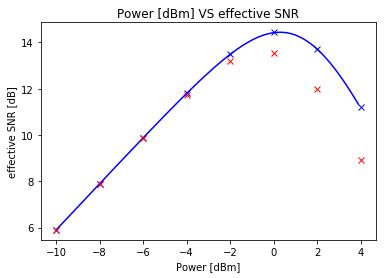

In [7]:
plt.plot(powerSweep, NLINeffSNR,'b')
plt.plot(wizard_powerSweep, wizard_effSNR,'bx')
plt.plot(fehen_powerSweep, fehen_effSNR,'rx')
plt.title('Power [dBm] VS effective SNR')
plt.xlabel('Power [dBm]')
plt.ylabel('effective SNR [dB]')
plt.show()